In [61]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import pandas as pd
import seaborn
import cv2
from facenet_pytorch import MTCNN
from PIL import Image

In [ ]:
# Здесь были развлечения с VideoCapture и MTCNN.. Я их удалил ))
# Переходим сразу к заготовке нашего кода (пока - детектинг лица)

In [362]:
class Detector():
    def __init__(self, mtcnn, detector):
        self.mtcnn = mtcnn
        self.detector = detector
        
    
    def run(self):
        cap = cv2.VideoCapture(0)

        while True:
            ret, frame = cap.read()
            
            if not ret:
                break
                
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            boxes, probs = self.mtcnn.detect(frame, landmarks=False)
            if boxes is not None and len(boxes) > 0:
                cropped = gray[int(boxes[0][1]):int(boxes[0][3]), int(boxes[0][0]):int(boxes[0][2])]
            
            if probs is not None and len(probs) > 0 and probs[0] is not None and probs[0] > 0.98:
                print('Face Detected')
                plt.imshow(cropped)
                cap.release()
                cv2.destroyAllWindows()
                break
            
            cv2.imshow('frame', gray)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                break
            

In [363]:
detector = Detector(MTCNN(), None)

Face Detected


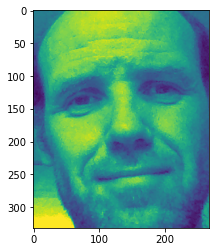

In [365]:
detector.run()

In [366]:
# MTCNN ожидаемо работает идеально

In [367]:
transforms = tt.Compose([tt.Grayscale(num_output_channels=1), 
                         tt.Resize((48, 48)),
                         tt.ToTensor()])

In [368]:
train_transforms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),           
                         tt.RandomRotation(30),
                         tt.Resize((48, 48)),
                         tt.ToTensor()])

In [369]:
dataset = ImageFolder('data/', train_transforms)

In [370]:
dataset

Dataset ImageFolder
    Number of datapoints: 20000
    Root location: data/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=(48, 48), interpolation=bilinear)
               ToTensor()
           )

In [371]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [19000,1000])

In [372]:
train_dataset

In [373]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)

In [374]:
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [375]:
i = iter(train_dataset)

In [376]:
image, label = i.__next__()

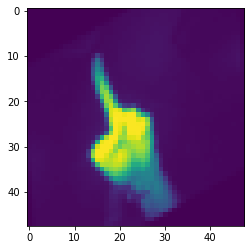

In [377]:
plt.imshow(image.permute((1,2,0)).reshape((48, 48)))

In [378]:
label

5

In [ ]:
# ResNet реализация с вебинара

In [231]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes),
                                        nn.Softmax(dim=1))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [232]:
resnet = ResNet(1, 10)

In [233]:
resnet

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [234]:
epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(resnet.parameters(), max_lr)

In [235]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

In [236]:
epoch_losses = []
true_y = []
pred_y = []

sm=nn.Softmax(dim=0)

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_loader):   
        
        optimizer.zero_grad()
        
        outputs = resnet(data)
        
        _, preds = torch.max(outputs, 1)
        
        true_y.append(labels)
        pred_y.append(outputs)
        
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)


Epoch 1, loss:  2.1568125319802
Epoch 2, loss:  1.7819915203133014
Epoch 3, loss:  1.7035982835573782
Epoch 4, loss:  1.6447243740662982
Epoch 5, loss:  1.5826071603129608
Epoch 6, loss:  1.56981022791429
Epoch 7, loss:  1.5662374913893164
Epoch 8, loss:  1.5633238768738127
Epoch 9, loss:  1.5610285744522556
Epoch 10, loss:  1.5605817796405317


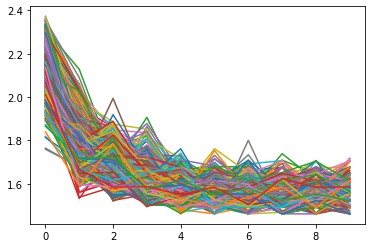

In [237]:
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.draw()

In [238]:
i = iter(test_loader)

In [253]:
image, label = i.__next__()

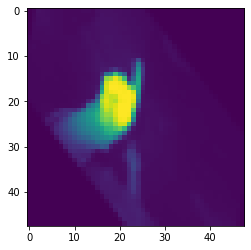

In [254]:
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))

In [255]:
image.shape

torch.Size([1, 1, 48, 48])

In [256]:
np.array(label)[0]

5

In [257]:
np.argmax(np.array(resnet(image).detach()))

5

In [ ]:
# Отлично - совпадает

5


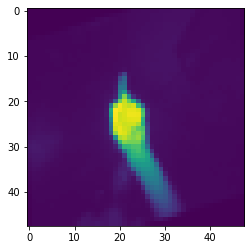

In [258]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [259]:
np.argmax(np.array(resnet(image).detach()))

5

In [ ]:
# Тут тоже 5 - 5

8


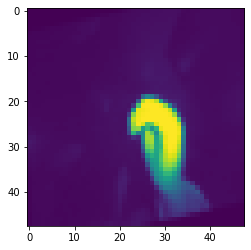

In [358]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [359]:
np.argmax(np.array(resnet(image).detach()))

8

In [379]:
# 8 - 8

In [262]:
# Пока угадывает. Осталось понять как он будет это делать на фотографиях с вебкамеры
# Проблема в том, что тренировались мы на IR фото, они достаточно сильно отличаются от обычной фотографии
# Насколько я понимаю depth картинки - это затухание яркости в глубину (по мере удаления от камеры)
# Получить такие "глубинные" фото можно с помощью немного специального устройства (эти были с LeapMotion)
# Из бытовых-более менее доступных - это Microsoft Kinekt, либо как-то научиться получать их с depth сенсора 
# Какого-нибудь iPhone - из более менее последних (начиная с iPhone X)
# Но это перечеркивает идею веб приложения общего назначения.. Поскольку мало у кого будет возможность использовать
# Такие устройства (даже в случае с iPhone - это тоже дополнительные действия для подключения и настройки)

In [285]:
cap = cv2.VideoCapture(0)

In [286]:
ret, frame = cap.read()

In [287]:
cap.release()

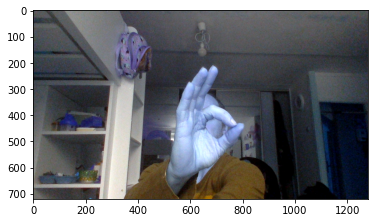

In [288]:
plt.imshow(frame)

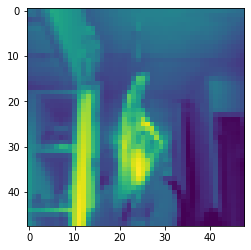

In [290]:
image = transforms(Image.fromarray(frame))
plt.imshow(image.permute(1, 2, 0).reshape((48, 48)))

In [291]:
# Шансов мне кажется - никаких
np.argmax(np.array(resnet(image.unsqueeze(0)).detach()))

1

In [360]:
# А должно быть 6.. 
# Возможно, чтобы хоть как-то приблизиться по картинке можно убрать фон (яркой фротнальной подсветкой от камеры)
# Опять-же - фронтальная подсветка в каком-то виде будет имитировать depth снимки - ближние объекты будут ярче
# Хоть это уже делает процесс съемки сложным, не подходящим для массового использования

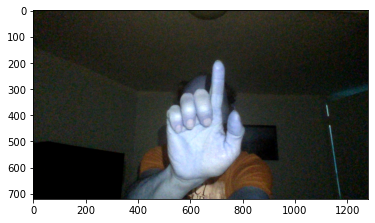

In [292]:
plt.imshow(frame1)

In [ ]:
# Еще можно повысить контраст между светлыми и темными областями - приводим в диапазон 0-1 и возводим в степень (гамма)

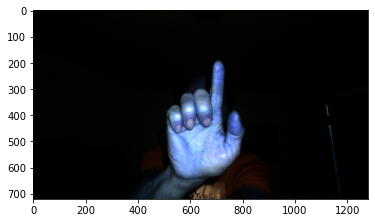

In [293]:
plt.imshow(((frame1/255)**2.5))

In [355]:
# Пробуем
image = transforms(Image.fromarray((((frame1/255.0)**2)*255).astype(np.uint8)))

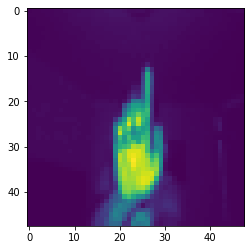

In [356]:
plt.imshow(image.permute(1, 2, 0).reshape((48, 48)))

In [357]:
np.argmax(np.array(resnet(image.unsqueeze(0)).detach()))

1

In [ ]:
# Нет

In [151]:
cap = cv2.VideoCapture(0)

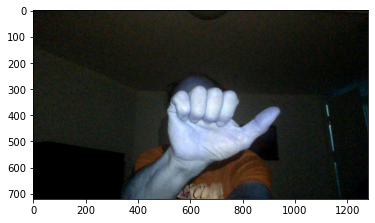

In [152]:
ret, frame2 = cap.read()
cap.release()
plt.imshow(frame2)

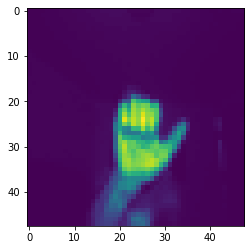

In [353]:
image2 = transforms(Image.fromarray((((frame2/255.0)**2)*255).astype(np.uint8)))
plt.imshow(image2.permute(1, 2, 0).reshape((48, 48)))

In [354]:
np.argmax(np.array(resnet(image2.unsqueeze(0)).detach()))

1

In [ ]:
# Тоже не то

In [153]:
cap = cv2.VideoCapture(0)

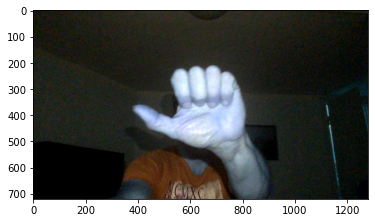

In [154]:
ret, frame3 = cap.read()
cap.release()
plt.imshow(frame3)

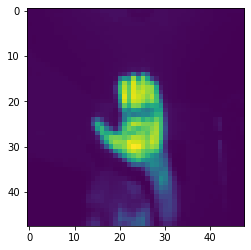

In [351]:
image3 = transforms(Image.fromarray((((frame3/255.0)**2)*255).astype(np.uint8)))
plt.imshow(image3.permute(1, 2, 0).reshape((48, 48)))

In [352]:
np.argmax(np.array(resnet(image3.unsqueeze(0)).detach()))

4

In [ ]:
# Ого! Угадан

In [155]:
cap = cv2.VideoCapture(0)

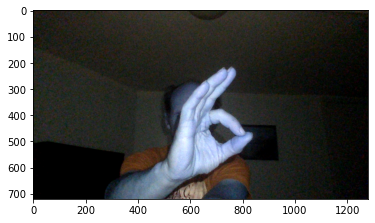

In [156]:
ret, frame4 = cap.read()
cap.release()
plt.imshow(frame4)

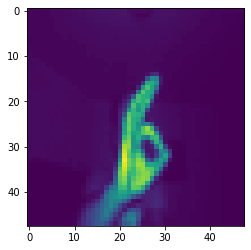

In [349]:
image4 = transforms(Image.fromarray((((frame4/255.0)**2)*255).astype(np.uint8)))
plt.imshow(image4.permute(1, 2, 0).reshape((48, 48)))

In [350]:
np.argmax(np.array(resnet(image4.unsqueeze(0)).detach()))

6

In [ ]:
# Этот угадан тоже

In [380]:
dataset = ImageFolder('data_binary/', train_transforms)

In [381]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [19000,1000])

In [383]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)

In [384]:
test_loader = DataLoader(train_dataset, batch_size = 1, shuffle=False)

In [385]:
i = iter(train_dataset)

In [386]:
image, label = i.__next__()

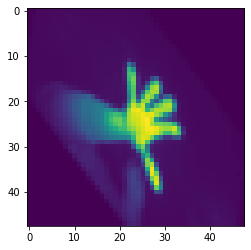

In [387]:
plt.imshow(image.permute((1,2,0)).reshape((48, 48)))

In [388]:
label

0

In [430]:
resnet = ResNet(1, 2)

In [431]:
epochs = 5
max_lr = 0.00005
grad_clip = 0.05
weight_decay = 1e-5
optimizer = torch.optim.Adam(resnet.parameters(), max_lr)

In [432]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

In [433]:
epoch_losses = []
true_y = []
pred_y = []

sm=nn.Softmax(dim=0)

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_loader):   
        
        optimizer.zero_grad()
        
        outputs = resnet(data)
        
        _, preds = torch.max(outputs, 1)
        
        true_y.append(labels)
        pred_y.append(outputs)
        
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)



Epoch 1, loss:  0.44684217503977947
Epoch 2, loss:  0.41252120225517835
Epoch 3, loss:  0.4125022229421821
Epoch 4, loss:  0.41243156193683445
Epoch 5, loss:  0.4125365738314812


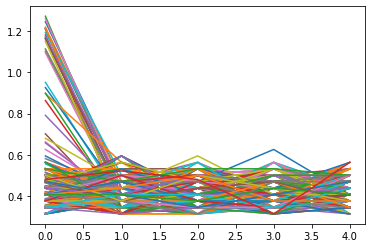

In [434]:
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.draw()

In [435]:
i = iter(test_loader)

0


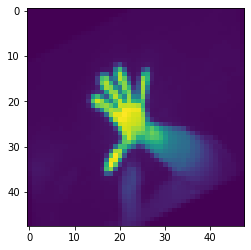

In [436]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [437]:
np.argmax(np.array(resnet(image).detach()))

0

1


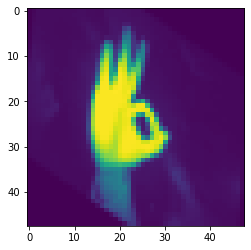

In [438]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [439]:
np.argmax(np.array(resnet(image).detach()))

0

0


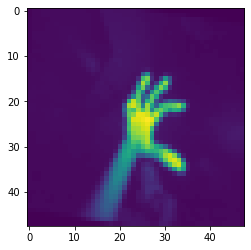

In [440]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [441]:
np.argmax(np.array(resnet(image).detach()))

0

1


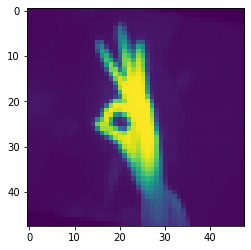

In [458]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [459]:
np.argmax(np.array(resnet(image).detach()))

0

1


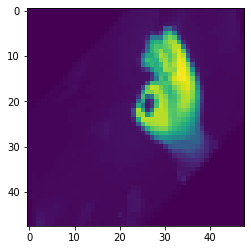

In [460]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [461]:
np.argmax(np.array(resnet(image).detach()))

0

Судя по результатам - такой подход не очень себя оправдывает. По крайней мере с нашей сетью.

In [464]:
# Вернемся к многоклассовому варианту
dataset = ImageFolder('data/', transforms)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [19000,1000])
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [469]:
resnet = ResNet(1, 10)

In [470]:
epochs = 5
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(resnet.parameters(), max_lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

In [471]:
%%time
epoch_losses = []
true_y = []
pred_y = []

sm=nn.Softmax(dim=0)

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_loader):   
        
        optimizer.zero_grad()
        
        outputs = resnet(data)
        
        _, preds = torch.max(outputs, 1)
        
        true_y.append(labels)
        pred_y.append(outputs)
        
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)


Epoch 1, loss:  1.9818115722049365
Epoch 2, loss:  1.6255626883169618
Epoch 3, loss:  1.5617896334490793
Epoch 4, loss:  1.557070543268313
Epoch 5, loss:  1.4625627340291085
CPU times: user 4h 15s, sys: 16min 27s, total: 4h 16min 43s
Wall time: 4h 31s


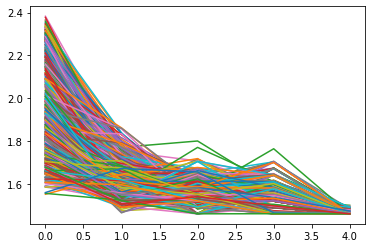

In [472]:
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.draw()

In [473]:
i = iter(test_loader)

8


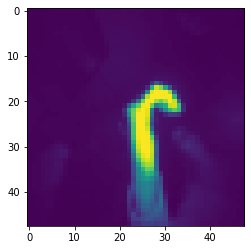

In [474]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [475]:
np.argmax(np.array(resnet(image).detach()))

8

3


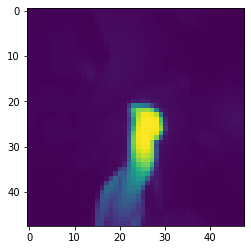

In [476]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [477]:
np.argmax(np.array(resnet(image).detach()))

5

1


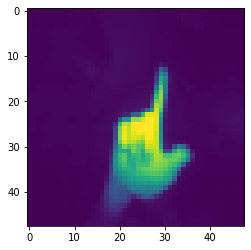

In [478]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [479]:
np.argmax(np.array(resnet(image).detach()))

1

3


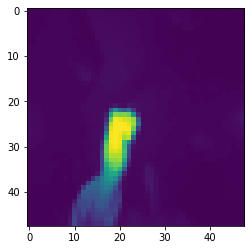

In [480]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [481]:
np.argmax(np.array(resnet(image).detach()))

8

8


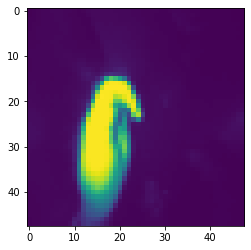

In [482]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [483]:
np.argmax(np.array(resnet(image).detach()))

8

5


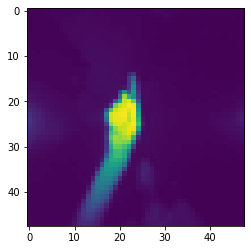

In [484]:
image, label = i.__next__()
plt.imshow(image[0].permute((1,2,0)).reshape((48, 48)))
print(np.array(label)[0])

In [485]:
np.argmax(np.array(resnet(image).detach()))

5

In [ ]:
# Вобщем - довольно неплохо со своими тестовыми данными справляется
# Попробуем теперь рискнуть еще раз со снятыми камерой
# Без специальных условий не обошлось - снималост с фронтальной подсветкой в темном помещении

In [489]:
cap = cv2.VideoCapture(0)

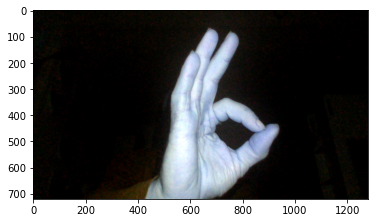

In [499]:
ret, frame1 = cap.read()
cap.release()
plt.imshow(frame1)

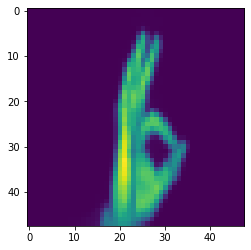

In [507]:
image1 = transforms(Image.fromarray((((frame1/255.0)**2)*255).astype(np.uint8)))
plt.imshow(image1.permute(1, 2, 0).reshape((48, 48)))

In [508]:
np.argmax(np.array(resnet(image1.unsqueeze(0)).detach()))

6

In [ ]:
# Угадал

In [491]:
cap = cv2.VideoCapture(0)

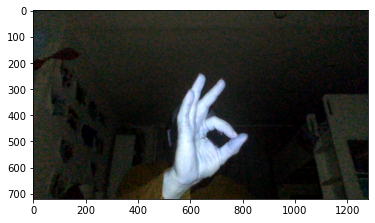

In [492]:
ret, frame2 = cap.read()
cap.release()
plt.imshow(frame2)

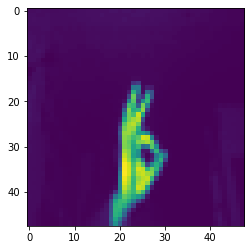

In [503]:
image2 = transforms(Image.fromarray((((frame2/255.0)**2)*255).astype(np.uint8)))
plt.imshow(image2.permute(1, 2, 0).reshape((48, 48)))

In [506]:
np.argmax(np.array(resnet(image2.unsqueeze(0)).detach()))

6

In [ ]:
# Угадал

In [495]:
cap = cv2.VideoCapture(0)

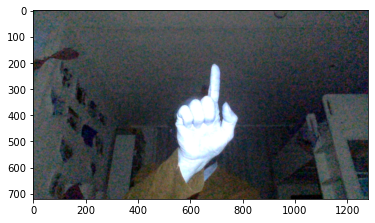

In [496]:
ret, frame3 = cap.read()
cap.release()
plt.imshow(frame3)

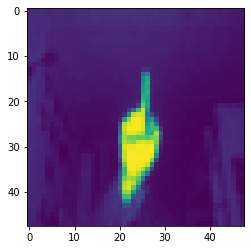

In [505]:
image3 = transforms(Image.fromarray((((frame3/255.0)**2)*255).astype(np.uint8)))
plt.imshow(image3.permute(1, 2, 0).reshape((48, 48)))

In [509]:
np.argmax(np.array(resnet(image3.unsqueeze(0)).detach()))

5

In [ ]:
# Верно

In [497]:
cap = cv2.VideoCapture(0)

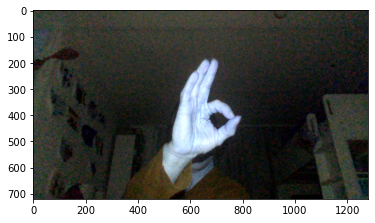

In [498]:
ret, frame4 = cap.read()
cap.release()
plt.imshow(frame4)

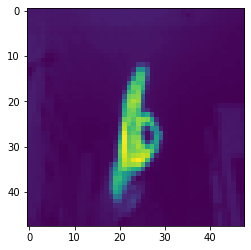

In [510]:
image4 = transforms(Image.fromarray((((frame4/255.0)**2)*255).astype(np.uint8)))
plt.imshow(image4.permute(1, 2, 0).reshape((48, 48)))

In [512]:
np.argmax(np.array(resnet(image4.unsqueeze(0)).detach()))

9

In [ ]:
# Не угадал

In [428]:
cap = cv2.VideoCapture(0)

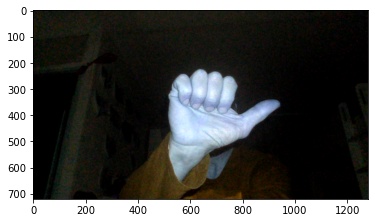

In [515]:
ret, frame5 = cap.read()
cap.release()
plt.imshow(frame5)

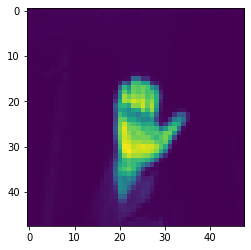

In [516]:
image5 = transforms(Image.fromarray((((frame5/255.0)**2)*255).astype(np.uint8)))
plt.imshow(image5.permute(1, 2, 0).reshape((48, 48)))

In [517]:
np.argmax(np.array(resnet(image5.unsqueeze(0)).detach()))

4

In [ ]:
# Угадан

In [518]:
# В завершении - тест со съемкой в обычных условиях
cap = cv2.VideoCapture(0)

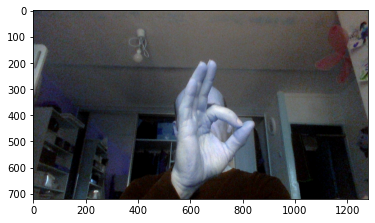

In [519]:
_, frame6 = cap.read()
cap.release()
plt.imshow(frame6)

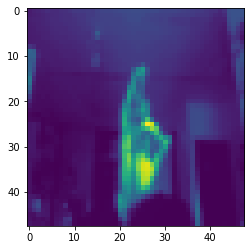

In [520]:
image6 = transforms(Image.fromarray((((frame6/255.0)**2)*255).astype(np.uint8)))
plt.imshow(image6.permute(1, 2, 0).reshape((48, 48)))

In [521]:
np.argmax(np.array(resnet(image6.unsqueeze(0)).detach()))

8

In [ ]:
# Мимо

In [528]:
cap = cv2.VideoCapture(0)

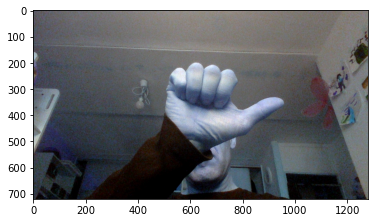

In [529]:
_, frame6 = cap.read()
cap.release()
plt.imshow(frame6)

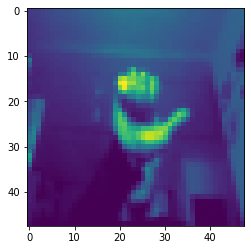

In [530]:
image6 = transforms(Image.fromarray((((frame6/255.0)**2)*255).astype(np.uint8)))
plt.imshow(image6.permute(1, 2, 0).reshape((48, 48)))

In [531]:
np.argmax(np.array(resnet(image6.unsqueeze(0)).detach()))

4

In [ ]:
# Хмм.. ну что-то угадать может
# Будем пробовать общую реализацию задачи

In [549]:
class Detector():
    def __init__(self, mtcnn, detector, target_gesture=6):
        self.mtcnn = mtcnn
        self.detector = detector
        self.target = target_gesture
        
    
    def run(self):
        
        # Face detection loop
        cap = cv2.VideoCapture(0)

        while True:
            ret, frame = cap.read()
            
            if not ret:
                break
                
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            boxes, probs = self.mtcnn.detect(frame, landmarks=False)
            if boxes is not None and len(boxes) > 0:
                cropped = gray[int(boxes[0][1]):int(boxes[0][3]), int(boxes[0][0]):int(boxes[0][2])]
            
            if probs is not None and len(probs) > 0 and probs[0] is not None and probs[0] > 0.98:
                print('Face Detected')
                plt.imshow(cropped)
                cap.release()
                cv2.destroyAllWindows()
                break
            
            cv2.imshow('frame', gray)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                break
        
        if detector:
            # Gesture recognition loop
            cap = cv2.VideoCapture(0)

            while True:

                _, frame = cap.read()
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                
                image = transforms(Image.fromarray((((frame/255.0)**2)*255).astype(np.uint8)))
                pred = np.argmax(np.array(resnet(image.unsqueeze(0)).detach()))
                print(pred)
                
                if pred == self.target:
                    plt.imshow(frame)
                    print('Got it! Bye..')
                    break
                
                cv2.imshow('frame', gray)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                
        cap.release()
        cv2.destroyAllWindows()        
            

In [550]:
detector = Detector(MTCNN(), resnet, target_gesture=6)

Face Detected
4
4
0
4
4
4
9
4
4
0
4
5
9
5
4
4
5
0
4
0
4
9
4
4
4
4
4
4
5
4
4
4
0
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
0
4
4
5
4
4
4
4
4
6
Got it! Bye..


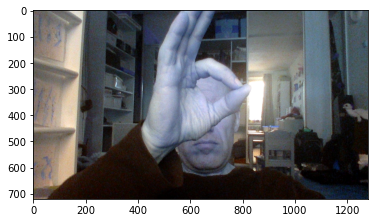

In [551]:
detector.run()

In [561]:
detector = Detector(MTCNN(), resnet, target_gesture=6)

Face Detected
4
6
Got it! Bye..


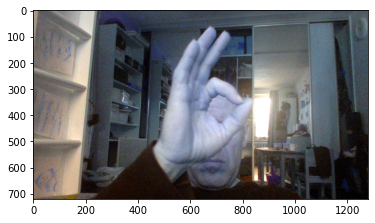

In [562]:
detector.run()

### Вывод
Если он тут нужен вообще

Вобщем с бооольшой натяжкой.... но как-то работает.
В моем понимании дело не в несовершенстве модели, а в неудачном выборе тренировочного датасета. (на тестовых данных того-же датасета результаты вполне себе достойные, а на том, что мы можем снять - довольно слабые)

Съемка в спец. условиях могла бы существенно повысить качество, но это сильно усложняет пользование подобным "приложением"..